In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import pickle
import torch
from tqdm import tqdm
from random import random

#sns darkgrid
sns.set_style("darkgrid")

%matplotlib inline
%cd /net/pulsar/home/koes/jok120/openfold

/net/pulsar/home/koes/jok120/openfold


# Create DataFrames

In [2]:
# get the model names from the list of directories in out/evaluation/230420/
# Don't use ! statements
model_names = os.listdir("out/evaluation/230420/")
model_paths = [f"out/evaluation/230420/{model_name}" for model_name in model_names]

df_dict = {"model": [], "eval_path": []}

for model_name, model_path in zip(model_names, model_paths):
    df_dict["model"].append(model_name)
    df_dict["eval_path"].append(model_path)

model_df = pd.DataFrame(df_dict)

# Add the test_results.pkl and the val_results.pkl paths to the DataFrame using a function
# that will be called with df.apply
def add_test_and_val_results_path(row):
    eval_path = row["eval_path"]
    row["test_results_path"] = f"{eval_path}/test_results.csv"
    row["val_results_path"] = f"{eval_path}/val_results.csv"
    return row

model_df = model_df.apply(add_test_and_val_results_path, axis=1)


model_df

,model,eval_path,test_results_path,val_results_path
0,initial_training_eval_s0,out/evaluation/230420/initial_training_eval_s0,out/evaluation/230420/initial_training_eval_s0...,out/evaluation/230420/initial_training_eval_s0...
1,baseline_scnmin_noomm_00_eval_s945,out/evaluation/230420/baseline_scnmin_noomm_00...,out/evaluation/230420/baseline_scnmin_noomm_00...,out/evaluation/230420/baseline_scnmin_noomm_00...
2,baseline_scnmin_noomm_00_eval_s3869,out/evaluation/230420/baseline_scnmin_noomm_00...,out/evaluation/230420/baseline_scnmin_noomm_00...,out/evaluation/230420/baseline_scnmin_noomm_00...
3,xfer_scnmin_omm_01_eval_s3675,out/evaluation/230420/xfer_scnmin_omm_01_eval_...,out/evaluation/230420/xfer_scnmin_omm_01_eval_...,out/evaluation/230420/xfer_scnmin_omm_01_eval_...
4,baseline_scnmin_omm_00c_eval_s1839,out/evaluation/230420/baseline_scnmin_omm_00c_...,out/evaluation/230420/baseline_scnmin_omm_00c_...,out/evaluation/230420/baseline_scnmin_omm_00c_...
5,xfer_scnmin_omm_02_eval_s5087,out/evaluation/230420/xfer_scnmin_omm_02_eval_...,out/evaluation/230420/xfer_scnmin_omm_02_eval_...,out/evaluation/230420/xfer_scnmin_omm_02_eval_...
6,xfer_scnmin_omm_03_eval_s2289,out/evaluation/230420/xfer_scnmin_omm_03_eval_...,out/evaluation/230420/xfer_scnmin_omm_03_eval_...,out/evaluation/230420/xfer_scnmin_omm_03_eval_...
7,xfer_scnmin_omm_04_eval_s1659,out/evaluation/230420/xfer_scnmin_omm_04_eval_...,out/evaluation/230420/xfer_scnmin_omm_04_eval_...,out/evaluation/230420/xfer_scnmin_omm_04_eval_...
8,xfer_scnmin_omm_05_eval_s1638,out/evaluation/230420/xfer_scnmin_omm_05_eval_...,out/evaluation/230420/xfer_scnmin_omm_05_eval_...,out/evaluation/230420/xfer_scnmin_omm_05_eval_...


# Make Scatterplots

In [3]:
    # plt.rcParams.update({'font.size':12,
    #                     'axes.titlesize':12,
    #                     'axes.labelsize':12,
    #                     'xtick.labelsize':12,
    #                     'ytick.labelsize':12,
    #                     'legend.fontsize':12,
    #                     'figure.titlesize':12,
    #                     })

In [8]:
# plt.ioff()
def make_accuracy_plot(dfx,
                       dfy,
                       dfx_name,
                       dfy_name,
                       dataset_split,
                       metric="gdcall_aa",
                       hue="",
                       use_log=False,
                       use_cube_root=False,
                       alpha=1,
                       size=3,
                       ax=None,
                       index=0,
                       save_prefix="",
                       fig=None,
                       ):
    """Make a scatter plot with seaborn comparing methods dfx and dfy on metric.
    Each row of the dataframes correspond to a different protein. For each protein,
    plot a point on the scatter plot with x-value equal to the metric value for dfx
    and y-value equal to the metric value for dfy.
    First join the dataframes on the protein column using suffixes to rename duplicate cols,
    then plot the metric values for each method.
    """
    

    df = dfx.merge(dfy, on="protein_name", suffixes=(f"_{dfx_name}", f"_{dfy_name}"))

    if use_log:
        df[f"{metric}_{dfx_name}_log"] = np.log(df[f"{metric}_{dfx_name}"])
        df[f"{metric}_{dfy_name}_log"] = np.log(df[f"{metric}_{dfy_name}"])
        xmetric = f"{metric}_{dfx_name}_log"
        ymetric = f"{metric}_{dfy_name}_log"
        metric = f"{metric}_log"
    elif use_cube_root:
        df[f"{metric}_{dfx_name}_cube_root"] = np.cbrt(df[f"{metric}_{dfx_name}"])
        df[f"{metric}_{dfy_name}_cube_root"] = np.cbrt(df[f"{metric}_{dfy_name}"])
        xmetric = f"{metric}_{dfx_name}_cube_root"
        ymetric = f"{metric}_{dfy_name}_cube_root"
        metric = f"{metric}_cube_root"
    else:
        xmetric = f"{metric}_{dfx_name}"
        ymetric = f"{metric}_{dfy_name}"

    # determine the min and max values over the x and y axis to set the limits of the plot uniformly
    # However, add a buffer to the min and max values so that the points are not on the edge of the plot
    min_val = min(df[xmetric].min(), df[ymetric].min())
    max_val = max(df[xmetric].max(), df[ymetric].max())
    # Add a buffer to the min and max values
    buffer = 0.05 * (max_val - min_val)
    min_val -= buffer
    max_val += buffer
    



    if ax is None:
        fig, ax = plt.subplots(figsize=(size*1.15, size));
        # fig, ax = plt.subplots();


    # Set the appropriate x and y axis limits using the fig and ax variables
    # Use the min and max values calculated above

    # make sure no limit is nan or inf
    if not np.isnan(min_val) and not np.isinf(min_val):
        ax.set_xlim(min_val, max_val)
        ax.set_ylim(min_val, max_val)

    
    # plot a dotted line y=x on the same figure without displaying it
    ax.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="black", alpha=0.5);


    # if hue is not empty, use it to color the points
    if hue:
        sns.scatterplot(data=df, x=xmetric, y=ymetric, hue=f"{hue}_{dfy_name}", ax=ax, alpha=alpha);
    else:
        sns.scatterplot(data=df, x=xmetric, y=ymetric, ax=ax, alpha=alpha);


    # Get the mean values for each method
    dfx_mean = df[xmetric].mean()
    dfy_mean = df[ymetric].mean()

    # Set the position of the box
    ax.text(
        0.05,
        0.95,
        f"y mean: {dfy_mean:.2f}\nx mean: {dfx_mean:.2f}",
        horizontalalignment="left",
        verticalalignment="top",
        transform=ax.transAxes,
        bbox=dict(boxstyle="square", facecolor="white", alpha=0.5),
    )

    # add a legend for the hue as a continuous colorbar with the title of the hue metric
    if hue:
        norm = plt.Normalize(dfy[hue].min(), dfy[hue].max())
        sm = plt.cm.ScalarMappable(norm=norm)
        sm.set_array([])
        ax.get_legend().remove()
        ax.figure.colorbar(sm)
        ax.figure.axes[-1].set_ylabel(f"{hue}");
                

    plt.xlabel(f"{dfx_name}");
    plt.ylabel(f"{dfy_name}");
    plt.title(f"{metric} : {dataset_split}");

    # Ensure a white background
    if fig:
        fig.patch.set_facecolor('white')

    # Save the plot
    if save_prefix:
        plt.savefig(f"{save_prefix}{index}.png", dpi=300, bbox_inches="tight")

    

    # Return the plot
    return ax




## Sample plots

In [5]:
baseline_sft = model_df[model_df["model"] == "initial_training_eval_s0"].head(1)
comparison_model = model_df[model_df["model"] == "xfer_scnmin_omm_04_eval_s1659"].head(1)
baseline_test_results = pd.read_csv(baseline_sft["test_results_path"].item())
comparison_test_results = pd.read_csv(comparison_model["test_results_path"].item())

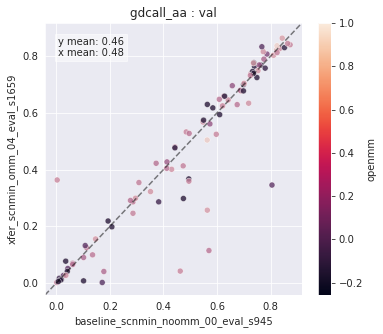

In [16]:
f = make_accuracy_plot(dfx=baseline_test_results,
dfy=comparison_test_results,
# dfx_name="initial_training_eval_s0",
dfx_name="baseline_scnmin_noomm_00_eval_s945",
dfy_name="xfer_scnmin_omm_04_eval_s1659",
dataset_split='val',
metric="gdcall_aa",
hue="openmm",
alpha=.81,
size=5)


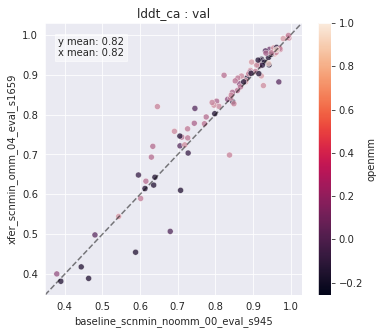

In [15]:
f = make_accuracy_plot(dfx=baseline_test_results,
dfy=comparison_test_results,
dfx_name="baseline_scnmin_noomm_00_eval_s945",
dfy_name="xfer_scnmin_omm_04_eval_s1659",
dataset_split='val',
metric="lddt_ca",
hue="openmm",
alpha=.8,
size=5)


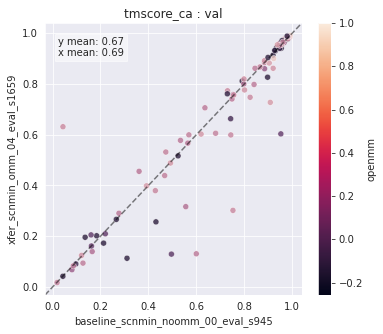

In [17]:
f = make_accuracy_plot(dfx=baseline_test_results,
dfy=comparison_test_results,
dfx_name="baseline_scnmin_noomm_00_eval_s945",
dfy_name="xfer_scnmin_omm_04_eval_s1659",
dataset_split='val',
metric="tmscore_ca",
hue="openmm",
alpha=.8,
size=5)


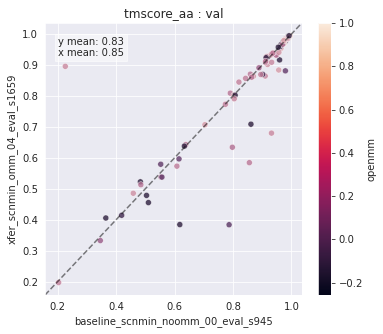

In [18]:
f = make_accuracy_plot(dfx=baseline_test_results,
dfy=comparison_test_results,
dfx_name="baseline_scnmin_noomm_00_eval_s945",
dfy_name="xfer_scnmin_omm_04_eval_s1659",
dataset_split='val',
metric="tmscore_aa",
hue="openmm",
alpha=.8,
size=5)


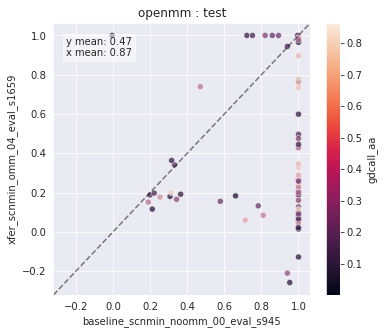

In [21]:
# TODO FIX DATASET SPLIT!! not chainging
f = make_accuracy_plot(dfx=baseline_test_results,
dfy=comparison_test_results,
dfx_name="baseline_scnmin_noomm_00_eval_s945",
dfy_name="xfer_scnmin_omm_04_eval_s1659",
dataset_split='test',
metric="openmm",
hue="gdcall_aa",
alpha=.8,
size=5)


In [ ]:
make_accuracy_plot(dfx=baseline_test_results,
dfy=comparison_test_results,
dfx_name="baseline_scnmin_noomm_00_eval_s945",
dfy_name="xfer_scnmin_omm_04_eval_s1659",
dataset_split='test',
metric="lddt_aa",
hue="openmm")


In [ ]:
make_accuracy_plot(dfx=baseline_test_results,
dfy=comparison_test_results,
dfx_name="baseline_scnmin_noomm_00_eval_s945",
dfy_name="xfer_scnmin_omm_04_eval_s1659",
dataset_split='test',
metric="lddt_ca",
hue="openmm")


In [ ]:
make_accuracy_plot(dfx=baseline_test_results,
dfy=comparison_test_results,
dfx_name="baseline_scnmin_noomm_00_eval_s945",
dfy_name="xfer_scnmin_omm_04_eval_s1659",
dataset_split='test',
metric="rmsd_aa",
hue="openmm")


In [ ]:
make_accuracy_plot(dfx=baseline_test_results,
dfy=comparison_test_results,
dfx_name="initial_training_eval_s0",
dfy_name="xfer_scnmin_omm_04_eval_s1659",
dataset_split='test',
metric='openmm_scaled',
hue="gdcall_aa")

In [ ]:
make_accuracy_plot(dfx=baseline_test_results,
dfy=comparison_test_results,
dfx_name="initial_training_eval_s0",
dfy_name="xfer_scnmin_omm_04_eval_s1659",
dataset_split='test',
metric='openmm_raw_energy',
use_log=False,
use_cube_root=True,
hue="gdcall_aa",
size=3)

## All Plots

In [ ]:
example_results_df = model_df[model_df["model"] == "initial_training_eval_s0"].head(1)
example_results_df = pd.read_csv(example_results_df["test_results_path"].item())
example_results_df.head()

In [ ]:
# Use the function make_accuracy_plot to make a 3 x N grid of plots
# It should use all combinations of the following:
# - for the x axis (dfx), use the models 'initial_trainint_eval_s0', 'baseline_scnmin_noomm_00_eval_s945', and 'baseline_scnmin_noomm_00_eval_s3869'
# - for the y axis (dfy), use all of the other non-x axis models ('baseline_scnmin_omm_00c_eval_s1839', 'initial_training_eval_s0', 'xfer_scnmin_omm_01_eval_s3675', 'xfer_scnmin_omm_02_eval_s5087', 'xfer_scnmin_omm_03_eval_s2289', 'xfer_scnmin_omm_04_eval_s1659', 'xfer_scnmin_omm_05_eval_s1638')
# - for the metric, use all of the columns in the dataframe except protein_name and phase
# - for the hue, use gdcall_aa when the metric contains openmm, otherwise use openmm
# - for each combination of the above, read the csv corresponding to each models test_results_path and val_results_path
# - for each combination of the above, use the dataset_split according to if the test_results or val_reults were loaded

# X-axis: filter model names from model_df that don't include 'initial' or 'noommm'
dfx_names = sorted(
    model_df[model_df["model"].str.contains("initial|noomm")]["model"].unique().tolist())
dfx_names

# Y-axis: return models that are not in the x-axis
dfy_names = sorted(
    model_df[~model_df["model"].isin(dfx_names)]["model"].unique().tolist())
dfy_names

# Metric: return all columns except protein_name and phase from example_results_df
metrics = example_results_df.columns.tolist()
to_remove = [
    "protein_name", "phase", "plddt_loss", "experimentally_resolved", "unscaled_loss",
    "seq_length", "openmm_scaled", "loss"
]
for item in to_remove:
    metrics.remove(item)
metrics


def get_df_from_name(name, set):
    this_df = model_df[model_df["model"] == name].head(1)
    if set == "test":
        this_df = pd.read_csv(this_df["test_results_path"].item())
    elif set == "val":
        this_df = pd.read_csv(this_df["val_results_path"].item())
    else:
        raise ValueError("set must be 'test' or 'val'")
    return this_df


def plot_arg_generator():
    for set in ["test", "val"]:
        for dfx_name in dfx_names:
            for dfy_name in dfy_names:
                for metric in metrics:
                    if "openmm" in metric:
                        hue = "gdcall_aa"
                    else:
                        hue = "openmm"
                    dfx = get_df_from_name(dfx_name, set)
                    dfy = get_df_from_name(dfy_name, set)
                    if "raw" in metric:
                        yield dfx, dfy, dfx_name, dfy_name, set, metric, hue, False, True
                    else:
                        yield dfx, dfy, dfx_name, dfy_name, set, metric, hue, False, False


In [ ]:
plt_args = list(plot_arg_generator())

In [ ]:
%%capture
plots = []

limit=18
for i, args in tqdm(enumerate(plt_args), total=len(plt_args)):
    p = make_accuracy_plot(
        *args,
        save_prefix="/net/pulsar/home/koes/jok120/openfold/jk_research/evaluations/230420/plots0425b/",
        index=i,
        size=1,
        alpha=0.9);
    plots.append(p)
    if i > limit: break

    

In [ ]:
756/9

In [ ]:
L = 4
W = 3
n_plots = 12 #len(plots)

# Create a grid of L x W subfigures
fig, axes = plt.subplots(L, W, figsize=(16, 16), sharex=False, sharey=False)

for i in range(L):
    for j in range(W):
        index = i * W + j
        print(index)
        if index > n_plots - 1:
            break
        make_accuracy_plot(*plt_args[index], ax=axes[i, j], size=3)
        # fig_ij = plots[index]
        # Copy the content of the returned figure to the subfigure
        # axes[i, j].imshow(fig_ij.canvas.buffer_rgba())

# Adjust spacing between subfigures
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Show the grid of subfigures
plt.show()

# Distribution plots

In [ ]:
plt.rcParams.update({'font.size':12,
                    'axes.titlesize':12,
                    'axes.labelsize':12,
                    'xtick.labelsize':12,
                    'ytick.labelsize':12,
                    'legend.fontsize':12,
                    'figure.titlesize':12,
                    'figure.figsize':(8,6),
                })

In [ ]:
metric = "openmm_raw_energy"
take_cube_root = True

before_model = "initial_training_eval_s0"
after_model = "xfer_scnmin_omm_04_eval_s1659"
after_model2 = "baseline_scnmin_noomm_00_eval_s945"

test_before = pd.read_csv(model_df[model_df["model"] == before_model]["test_results_path"].item())
test_after = pd.read_csv(model_df[model_df["model"] == after_model]["test_results_path"].item())
test_after2 = pd.read_csv(model_df[model_df["model"] == after_model2]["test_results_path"].item())

if take_cube_root:
    test_before[metric + "_cbrt"] = test_before[metric].apply(np.cbrt)
    test_after[metric + "_cbrt"] = test_after[metric].apply(np.cbrt)
    test_after2[metric + "_cbrt"] = test_after2[metric].apply(np.cbrt)
    metric += "_cbrt"

# min_val = min(test_before[metric].min(), test_after[metric].min(), test_after2[metric].min())
# max_val = max(test_before[metric].max(), test_after[metric].max(), test_after2[metric].max())
# bins = np.linspace(min_val, max_val, 100)
bins = 'auto'

# # determine the maximum bin count
# max_bin_count = max(
#     np.histogram(test_before[metric], bins=bins)[0].max(),
#     np.histogram(test_after[metric], bins=bins)[0].max(),
#     np.histogram(test_after2[metric], bins=bins)[0].max()
# )
# # set ylim to maximum bin count
# # max_bin_count = None
# plt.ylim(0, max_bin_count)



# sns.histplot(test_before[metric], label="before", bins=bins, color="tab:blue")
# plt.xlabel("OpenMM-based Loss Fn")
# plt.ylabel("Frequency")
# plt.title(before_model)
# # plt.savefig("test_before.svg")
# plt.figure()

# sns.histplot(test_after2[metric], label=after_model2, bins=bins, color="tab:green")
# plt.xlabel("OpenMM-based Loss Fn")
# plt.ylabel("Frequency")
# plt.title(after_model2)
# # plt.legend()
# # plt.savefig("test_after.svg")
# plt.ylim(0, max_bin_count)
# plt.figure()



sns.histplot(test_after[metric][test_after[metric] < 5000], label=after_model, bins=bins, color="tab:orange")
plt.xlabel("OpenMM-based Loss Fn")
plt.ylabel("Frequency")
plt.title(after_model)
# plt.legend()
# plt.savefig("test_after.svg")
# plt.ylim(0, max_bin_count)
plt.show()



In [ ]:
test_after[metric]

In [ ]:
before_model = "initial_training_eval_s0"
after_model2 = "baseline_scnmin_noomm_00_eval_s945"

test_before = pd.read_csv(model_df[model_df["model"] == before_model]["test_results_path"].item())
test_after2 = pd.read_csv(model_df[model_df["model"] == after_model2]["test_results_path"].item())

min_val = min(test_before["openmm"].min(), test_after["openmm"].min())
max_val = max(test_before["openmm"].max(), test_after["openmm"].max())
bins = np.linspace(min_val, max_val, 25)

sns.histplot(test_before["openmm"], label="before", bins=bins, color="tab:blue")
plt.xlabel("OpenMM-based Loss Fn")
plt.ylabel("Frequency")
plt.title(before_model)
# plt.savefig("test_before.svg")
plt.figure()

sns.histplot(test_after["openmm"], label="after", bins=bins, color="tab:orange")
plt.xlabel("OpenMM-based Loss Fn")
plt.ylabel("Frequency")
plt.title(after_model2)
# plt.legend()
# plt.savefig("test_after.svg")
plt.show()
